<a href="https://colab.research.google.com/github/vincentbriat/Super-resolution-investigation/blob/main/Discriminator_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Checks if the code is in a colab notebook

try:
  from google.colab import drive
  IN_COLAB = True
except:
  IN_COLAB = False

Run on Colab notebook

In [3]:
if IN_COLAB:
  !pip install basicsr
  drive.mount('/content/drive/')
  !unzip /content/drive/MyDrive/Datasets/DIV2K_valid_HR.zip
  !unzip /content/drive/MyDrive/Datasets/DIV2K_valid_LR_clean.zip
  !unzip /content/drive/MyDrive/Datasets/DIV2K_train_LR_clean.zip
  #!unzip /content/drive/MyDrive/Datasets/DIV2K_train_HR.zip
  !unzip /content/drive/MyDrive/ML/Indiv_Project/Second_Year/Pruning/80_percent/gen_images_0.zip
  FOLDER_LR_TEST = 'DIV2K_valid_LR_clean'
  FOLDER_HR_TEST = 'DIV2K_valid_HR'
  FOLDER_LR_TRAIN = 'DIV2K_train_LR_clean'
  #FOLDER_HR_TRAIN = 'DIV2K_train_HR'
  FOLDER_GEN_IMAGES = 'gen_images_0'

  STUDENT_MODEL_PATH = 'drive/MyDrive/ML/Indiv_Project/Second_Year/KD/Models/student.pth'
  STUDENT_RECORDS_PATH = 'drive/MyDrive/ML/Indiv_Project/Second_Year/KD/Models/student.csv'
  GENERATOR_MODEL_PATH = 'drive/MyDrive/ML/Indiv_Project/Second_Year/KD/Models/generator.pth'
  GENERATOR_RECORDS_PATH = 'drive/MyDrive/ML/Indiv_Project/Second_Year/KD/Models/generator.csv'
  DISCRIMINATOR_MODEL_PATH = 'drive/MyDrive/ML/Indiv_Project/Second_Year/Pruning/80_percent/discriminator.pth'
  DISCRIMINATOR_RECORDS_PATH = 'drive/MyDrive/ML/Indiv_Project/Second_Year/Pruning/80_percent/discriminator.csv'

  TEACHER_MODEL_PATH = 'drive/MyDrive/ML/Indiv_Project/Second_Year/KD/ESRGAN_models/RealESRGAN_x4plus.pth'

Run on my Windows desktop

In [4]:
if not IN_COLAB:
  FOLDER_LR_TEST = 'D:\Downloads\Div2k\DIV2K_valid_LR_clean'
  FOLDER_HR_TEST = 'D:\Downloads\Div2k\DIV2K_valid_HR'
  FOLDER_LR_TRAIN = 'D:\Downloads\Div2k\DIV2K_train_LR_clean'
  FOLDER_HR_TRAIN = 'D:\Downloads\Div2k\DIV2K_train_HR'
  
  STUDENT_MODEL_PATH='D:\oldDrive\ML\Indiv_Project\Second_Year\KD\Models\student.pth'
  STUDENT_RECORDS_PATH='D:\oldDrive\ML\Indiv_Project\Second_Year\KD\Models\student.csv'
  GENERATOR_MODEL_PATH='D:\oldDrive\ML\Indiv_Project\Second_Year\KD\Models\generator.pth'
  GENERATOR_RECORDS_PATH='D:\oldDrive\ML\Indiv_Project\Second_Year\KD\Models\generator.csv'
  DISCRIMINATOR_MODEL_PATH = 'D:\oldDrive\ML\Indiv_Project\Second_Year\Pruning\80_percent\discriminator.pth'
  DISCRIMINATOR_RECORDS_PATH = 'D:\oldDrive\ML\Indiv_Project\Second_Year\Pruning\80_percent\discriminator.csv'
  
  TEACHER_MODEL_PATH = 'D:\oldDrive\ML\Indiv_Project\Second_Year\KD\ESRGAN_models\RealESRGAN_x4plus.pth'

# Setup

In [5]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import cv2
import csv
import math
import numpy as np
import os
import queue
import threading
from basicsr.archs.rrdbnet_arch import RRDBNet
import torchvision
from os import listdir, environ, path
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models import vgg19

# Making sure to use the gpu, if available
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# torch.cuda.set_device(torch.device(0))

c:\Users\Vincent\anaconda3\envs\ai-robotics\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
class DIV2KLoader(object):
  def __init__(self,  low_res_folder, low_res_size: int = 48, high_res_folder = None, preprocessing_input = None, preprocessing_output = None, include_targets = True):
    self.low_res_folder = low_res_folder
    self.high_res_folder = high_res_folder
    self.img_names = sorted(listdir(low_res_folder))
    self.include_targets = include_targets
    self.len = len(self.img_names)
    self.crop = torchvision.transforms.RandomCrop(low_res_size*4)
    self.resize = torchvision.transforms.Resize(low_res_size)
    
    if include_targets or high_res_folder is not None:
      self.target_names = sorted(listdir(high_res_folder))

    if preprocessing_input is None:
      self.preprocessing_input = torchvision.transforms.ToTensor()
    else:
      self.preprocessing_input = preprocessing_input

    if preprocessing_output is None:
      self.preprocessing_output = torchvision.transforms.ToTensor()
    else:
      self.preprocessing_output = preprocessing_output
  
  def __getitem__(self, i):
    # Get the right image
    img = Image.open(Path(self.low_res_folder).joinpath(self.img_names[i]))

    if self.include_targets and self.high_res_folder:
      target = Image.open(Path(self.high_res_folder).joinpath(self.target_names[i]))
      return self.preprocessing_input(img), self.preprocessing_output(target)
    
    # if include_targets is True and there's only one set of images
    elif self.include_targets and not self.high_res_folder:
      target = self.crop(self.preprocessing_input(img))
      return self.resize(target), target

    else:
      return self.preprocessing_input(img)

  def __len__(self):
    return self.len
  
  def restrict_size(self, size):
    if size < len(self.img_names) and size > 0:
      self.len = size
    else:
      self.len = len(self.img_names)
      print(f"Size must be between 0 and {len(self.img_names)}")


# -----------------------------------------------------------------------------------


class Loader_D(DIV2KLoader):
  def __init__(self, fake_folder, crop_size: int, real_folder = None):
    super().__init__(fake_folder)
    self.img_names = sorted(listdir(fake_folder))
    self.fake_folder = fake_folder
    self.real_folder = real_folder
    self.len = len(self.img_names)
    self.crop_size = crop_size
    self.include_targets = False
    
    if real_folder:
      self.include_targets = True
      self.target_names = sorted(listdir(real_folder))
    
  def __getitem__(self, i):
    # Get the right image
    img = Image.open(Path(self.fake_folder).joinpath(self.img_names[i]))
    img = torchvision.transforms.ToTensor()(img)


    if self.include_targets:
      target = Image.open(Path(self.real_folder).joinpath(self.target_names[i]))
      target = torchvision.transforms.ToTensor()(target)

      x, y, h, w = torchvision.transforms.RandomCrop.get_params(img, output_size=(self.crop_size, self.crop_size))

      img = torchvision.transforms.functional.crop(img, x, y, h, w)
      target = torchvision.transforms.functional.crop(target, x, y, h, w)

      return img, target
    else:
      return img

# RealESRGAN

In [7]:
# https://github.com/xinntao/Real-ESRGAN/blob/5ca1078535923d485892caee7d7804380bfc87fd/realesrgan/utils.py

from torch.nn import functional as F
import cv2
import math
import numpy as np
import os
import queue
import threading

class RealESRGANer():
    """A helper class for upsampling images with RealESRGAN.
    Args:
        scale (int): Upsampling scale factor used in the networks. It is usually 2 or 4.
        model_path (str): The path to the pretrained model.
        model (nn.Module): The defined network. Default: None.
        tile (int): As too large images result in the out of GPU memory issue, so this tile option will first crop
            input images into tiles, and then process each of them. Finally, they will be merged into one image.
            0 denotes for do not use tile. Default: 0.
        tile_pad (int): The pad size for each tile, to remove border artifacts. Default: 10.
        pre_pad (int): Pad the input images to avoid border artifacts. Default: 10.
        half (bool): Whether to use half precision during inference. Default: False.
    """

    def __init__(self,
                 model_path,
                 tile=0,
                 tile_pad=10,
                 pre_pad=10,
                 half=False,
                 device=None,
                 gpu_id=None):
        self.tile_size = tile
        self.tile_pad = tile_pad
        self.pre_pad = pre_pad
        self.mod_scale = None
        self.half = half

        self.scale = 4

        # initialize model
        if gpu_id:
            self.device = torch.device(
                f'cuda:{gpu_id}' if torch.cuda.is_available() else 'cpu') if device is None else device
        else:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') if device is None else device

        loadnet = torch.load(model_path, map_location=torch.device('cpu'))

        # prefer to use params_ema
        if 'params_ema' in loadnet:
            keyname = 'params_ema'
        else:
            keyname = 'params'
        
        model = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32, scale=4)
        model.load_state_dict(loadnet[keyname], strict=True)

        model.eval()
        self.model = model.to(self.device)
        if self.half:
            self.model = self.model.half()

    def dni(self, net_a, net_b, dni_weight, key='params', loc='cpu'):
        """Deep network interpolation.
        ``Paper: Deep Network Interpolation for Continuous Imagery Effect Transition``
        """
        net_a = torch.load(net_a, map_location=torch.device(loc))
        net_b = torch.load(net_b, map_location=torch.device(loc))
        for k, v_a in net_a[key].items():
            net_a[key][k] = dni_weight[0] * v_a + dni_weight[1] * net_b[key][k]
        return net_a

    def pre_process(self, img):
        """Pre-process, such as pre-pad and mod pad, so that the images can be divisible
        """
        img = torch.from_numpy(np.transpose(img, (2, 0, 1))).float()
        self.img = img.unsqueeze(0).to(self.device)
        if self.half:
            self.img = self.img.half()

        # pre_pad
        if self.pre_pad != 0:
            self.img = F.pad(self.img, (0, self.pre_pad, 0, self.pre_pad), 'reflect')
        # mod pad for divisible borders
        if self.scale == 2:
            self.mod_scale = 2
        elif self.scale == 1:
            self.mod_scale = 4
        if self.mod_scale is not None:
            self.mod_pad_h, self.mod_pad_w = 0, 0
            _, _, h, w = self.img.size()
            if (h % self.mod_scale != 0):
                self.mod_pad_h = (self.mod_scale - h % self.mod_scale)
            if (w % self.mod_scale != 0):
                self.mod_pad_w = (self.mod_scale - w % self.mod_scale)
            self.img = F.pad(self.img, (0, self.mod_pad_w, 0, self.mod_pad_h), 'reflect')

    def process(self):
        # model inference
        self.output = self.model(self.img)

    def tile_process(self):
        """It will first crop input images to tiles, and then process each tile.
        Finally, all the processed tiles are merged into one images.
        Modified from: https://github.com/ata4/esrgan-launcher
        """
        batch, channel, height, width = self.img.shape
        output_height = height * self.scale
        output_width = width * self.scale
        output_shape = (batch, channel, output_height, output_width)

        # start with black image
        self.output = self.img.new_zeros(output_shape)
        tiles_x = math.ceil(width / self.tile_size)
        tiles_y = math.ceil(height / self.tile_size)

        # loop over all tiles
        for y in range(tiles_y):
            for x in range(tiles_x):
                # extract tile from input image
                ofs_x = x * self.tile_size
                ofs_y = y * self.tile_size
                # input tile area on total image
                input_start_x = ofs_x
                input_end_x = min(ofs_x + self.tile_size, width)
                input_start_y = ofs_y
                input_end_y = min(ofs_y + self.tile_size, height)

                # input tile area on total image with padding
                input_start_x_pad = max(input_start_x - self.tile_pad, 0)
                input_end_x_pad = min(input_end_x + self.tile_pad, width)
                input_start_y_pad = max(input_start_y - self.tile_pad, 0)
                input_end_y_pad = min(input_end_y + self.tile_pad, height)

                # input tile dimensions
                input_tile_width = input_end_x - input_start_x
                input_tile_height = input_end_y - input_start_y
                tile_idx = y * tiles_x + x + 1
                input_tile = self.img[:, :, input_start_y_pad:input_end_y_pad, input_start_x_pad:input_end_x_pad]

                # upscale tile
                try:
                    with torch.no_grad():
                        output_tile = self.model(input_tile)
                except RuntimeError as error:
                    print('Error', error)
                print(f'\tTile {tile_idx}/{tiles_x * tiles_y}')

                # output tile area on total image
                output_start_x = input_start_x * self.scale
                output_end_x = input_end_x * self.scale
                output_start_y = input_start_y * self.scale
                output_end_y = input_end_y * self.scale

                # output tile area without padding
                output_start_x_tile = (input_start_x - input_start_x_pad) * self.scale
                output_end_x_tile = output_start_x_tile + input_tile_width * self.scale
                output_start_y_tile = (input_start_y - input_start_y_pad) * self.scale
                output_end_y_tile = output_start_y_tile + input_tile_height * self.scale

                # put tile into output image
                self.output[:, :, output_start_y:output_end_y,
                            output_start_x:output_end_x] = output_tile[:, :, output_start_y_tile:output_end_y_tile,
                                                                       output_start_x_tile:output_end_x_tile]

    def post_process(self):
        # remove extra pad
        if self.mod_scale is not None:
            _, _, h, w = self.output.size()
            self.output = self.output[:, :, 0:h - self.mod_pad_h * self.scale, 0:w - self.mod_pad_w * self.scale]
        # remove prepad
        if self.pre_pad != 0:
            _, _, h, w = self.output.size()
            self.output = self.output[:, :, 0:h - self.pre_pad * self.scale, 0:w - self.pre_pad * self.scale]
        return self.output

    @torch.no_grad()
    def enhance(self, img: np.array, alpha_upsampler='realesrgan'):
        h_input, w_input = img.shape[0:2]
        # img: numpy
        img = img.astype(np.float32)
        if np.max(img) > 256:  # 16-bit image
            max_range = 65535
            print('\tInput is a 16-bit image')
        else:
            max_range = 255
        img = img / max_range
        if len(img.shape) == 2:  # gray image
            img_mode = 'L'
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        elif img.shape[2] == 4:  # RGBA image with alpha channel
            img_mode = 'RGBA'
            alpha = img[:, :, 3]
            img = img[:, :, 0:3]
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            if alpha_upsampler == 'realesrgan':
                alpha = cv2.cvtColor(alpha, cv2.COLOR_GRAY2RGB)
        else:
            img_mode = 'RGB'
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # ------------------- process image (without the alpha channel) ------------------- #
        self.pre_process(img)
        if self.tile_size > 0:
            self.tile_process()
        else:
            self.process()
        output_img = self.post_process()
        output_img = output_img.data.squeeze().float().cpu().clamp_(0, 1).numpy()
        output_img = np.transpose(output_img[[2, 1, 0], :, :], (1, 2, 0))
        if img_mode == 'L':
            output_img = cv2.cvtColor(output_img, cv2.COLOR_BGR2GRAY)

        # ------------------- process the alpha channel if necessary ------------------- #
        if img_mode == 'RGBA':
            print('Processing alpha channel:----------------')
            if alpha_upsampler == 'realesrgan':
                self.pre_process(alpha)
                if self.tile_size > 0:
                    self.tile_process()
                else:
                    self.process()
                output_alpha = self.post_process()
                output_alpha = output_alpha.data.squeeze().float().cpu().clamp_(0, 1).numpy()
                output_alpha = np.transpose(output_alpha[[2, 1, 0], :, :], (1, 2, 0))
                output_alpha = cv2.cvtColor(output_alpha, cv2.COLOR_BGR2GRAY)
            else:  # use the cv2 resize for alpha channel
                h, w = alpha.shape[0:2]
                output_alpha = cv2.resize(alpha, (w * self.scale, h * self.scale), interpolation=cv2.INTER_LINEAR)

            # merge the alpha channel
            output_img = cv2.cvtColor(output_img, cv2.COLOR_BGR2BGRA)
            output_img[:, :, 3] = output_alpha

        # ------------------------------ return ------------------------------ #
        if max_range == 65535:  # 16-bit image
            output = (output_img * 65535.0).round().astype(np.uint16)
        else:
            output = (output_img * 255.0).round().astype(np.uint8)

        return output


class PrefetchReader(threading.Thread):
    """Prefetch images.
    Args:
        img_list (list[str]): A image list of image paths to be read.
        num_prefetch_queue (int): Number of prefetch queue.
    """

    def __init__(self, img_list, num_prefetch_queue):
        super().__init__()
        self.que = queue.Queue(num_prefetch_queue)
        self.img_list = img_list

    def run(self):
        for img_path in self.img_list:
            img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            self.que.put(img)

        self.que.put(None)

    def __next__(self):
        next_item = self.que.get()
        if next_item is None:
            raise StopIteration
        return next_item

    def __iter__(self):
        return self


class IOConsumer(threading.Thread):

    def __init__(self, opt, que, qid):
        super().__init__()
        self._queue = que
        self.qid = qid
        self.opt = opt

    def run(self):
        while True:
            msg = self._queue.get()
            if isinstance(msg, str) and msg == 'quit':
                break

            output = msg['output']
            save_path = msg['save_path']
            cv2.imwrite(save_path, output)
        print(f'IO worker {self.qid} is done.')

# Discriminator

In [8]:
# http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006

class ConvBlock(nn.Module):
  def __init__(self, in_channels: int, out_channels: int, kernel_size: int, use_act: bool = True, **kwargs):
    super().__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, **kwargs)
    self.bn = nn.BatchNorm2d(out_channels)
    self.activation = nn.ReLU(inplace = True) if use_act else nn.Identity()

  def forward(self, x):
    return self.activation(self.conv(x))

class ResidualBlock_v1(nn.Module):
  def __init__(self, in_channels):
    super().__init__()
    self.block = nn.Sequential(
        ConvBlock(in_channels, in_channels, 3, stride=1, padding=1),
        ConvBlock(in_channels, in_channels, 3, stride=1, padding=1))

  def forward(self, x):
    return x + self.block(x)

class ResidualBlock_v2(nn.Module):
  def __init__(self, in_channels, mid_channels, **kwargs):
    super().__init__()
    self.block = nn.Sequential(ConvBlock(in_channels, mid_channels, 1, padding=0, **kwargs),
                               ConvBlock(mid_channels, mid_channels, 3, padding=1, stride=1),
                               ConvBlock(mid_channels, mid_channels*4, 1, padding=0, stride=1, use_act = False))
    
    if in_channels == mid_channels*4:
      self.residual = nn.Identity()
    else:
      self.residual = ConvBlock(in_channels, mid_channels*4, 1, padding=0, stride=1 if in_channels == mid_channels else 2, use_act = False)

  def forward(self, x):
    return self.block(x) + self.residual(x)

class ResNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.head = nn.Sequential(ConvBlock(3, 64, 7, stride=2), nn.MaxPool2d(3, 2))
    self.body = nn.Identity()
    self.tail = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)),
                              nn.Flatten(),
                              nn.Linear(2048,1))
    
  def forward(self, x):
      return self.tail(self.body(self.head(x)))

class ResNet_18(ResNet):
  def __init__(self):
    super().__init__()
    architecture = [64, 128, 256, 512]
    self.body = nn.Sequential(*[self._makeBlock(channels) for channels in architecture])

  def _makeBlock(self, in_channels):
    return nn.Sequential(ResidualBlock_v1(in_channels), ResidualBlock_v1(in_channels))

class ResNet_50(ResNet):
  def __init__(self):
    super().__init__()
    architecture = [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3
    self.body = self._makeBlock(architecture)
  
  def _makeBlock(self, architecture):
    layers = [ResidualBlock_v2(64, 64, stride=1)]

    for i in range(1, len(architecture)):
      mid_channels = architecture[i]
      in_channels = architecture[i-1] * 4
      layers.append(ResidualBlock_v2(in_channels, mid_channels, stride=1 if architecture[i-1] == architecture[i] else 2))

    return nn.Sequential(*layers)

# Follows the guidelines of https://github.com/soumith/ganhacks
class Discriminator(nn.Module):
  def __init__(self, model: nn.Module):
    super().__init__()
    self.model = model
    self.loss_fn = nn.BCELoss()
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=4e-4)
    self.cur_epoch = 0

  def forward(self, x):
    return self.model(x)

  def train_one_epoch(self, dataloader):
    self.model.train()
    self.model.to(DEVICE)
    cumu_loss = 0
    accuracy = 0
    # This dataloader outputs (Generator(LR_images), HR_images)
    for batch, (X, y) in enumerate(dataloader):
      fake, real = X.to(DEVICE), y.to(DEVICE)
      
      out = torch.cat([fake, real])
      out = torch.sigmoid(self.model(out))
      target = torch.cat([torch.zeros((fake.shape[0], 1)), torch.ones((real.shape[0], 1))]).to(DEVICE)

      loss = self.loss_fn(out, target)
      cumu_loss += loss.item()
      
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()
      
      out = (out > 0.5).float()
      accuracy_tmp = (torch.count_nonzero(out == target) / target.shape[0]).item()
      accuracy += accuracy_tmp

      if batch % 1 == 0:
        print('--------------------------')
        print(f'Trained batch {batch} with loss {loss.item()}')
        print(f'Accuracy: {accuracy_tmp}')

    return {'loss': cumu_loss/len(dataloader), 'accuracy': accuracy/len(dataloader)}

  def run_training(self, dataloader, epochs, path_record:str = None, path_model: str = None, load_epoch: bool = True):
    # Initializes the records file if not existant
    
    if path_record and not Path(path_record).is_file():
      self.initialize_csv(path_record)
      self.cur_epoch = 0
    elif load_epoch:
      # Loads the next epoch to continue training
      self.load_cur_epoch(path_record)

    while self.cur_epoch < epochs:
      print(f'Epoch: {self.cur_epoch}')
      result = self.train_one_epoch(dataloader)
      print(f'Total Loss: {result["loss"]}')
      print(f'Total Accuracy: {result["accuracy"]}')

      if path_record:
        self.record(path_record, [self.cur_epoch, result['loss'], result['accuracy']])
      if path_model:
        self.save(path_model)
      self.cur_epoch += 1

  def load_cur_epoch(self, path):
    with open(path) as records_file:
      epoch = records_file.readlines()[-1].split(',')[0]
      self.cur_epoch = int(epoch) + 1
  
  def load(self, path):
    saved_info = torch.load(path, map_location='cpu')
    self.model.load_state_dict(saved_info['model_state_dict'])
    self.model.to(DEVICE)
    self.optimizer.load_state_dict(saved_info['optimizer_state_dict'])
    #self.scheduler.load_state_dict(saved_info['lr_scheduler_state_dict'])
    self.loss_fn = saved_info['loss_fn']

  def save(self, path):
    torch.save({'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'loss_fn': self.loss_fn,
                'lr_scheduler_state_dict': 0},
               path)
    print("Discriminator saved Successfully!")

  def initialize_csv(self, path):
    self.record(path, ['Epoch', 'Loss', 'Accuracy'])
    print("Records created Successfully!")

  def record(self, path, row):
    with open(path, 'a', newline='') as f:
      csv.writer(f).writerow(row)
    print("Discriminator recorded Successfully!")

In [63]:
class VGGLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = vgg19(pretrained=True).features[:35].eval().to(DEVICE)

        for param in self.vgg.parameters():
            param.requires_grad = False

        self.loss = nn.L1Loss()

    def forward(self, input, target):
        vgg_input_features = self.vgg(input)
        vgg_target_features = self.vgg(target)
        return self.loss(vgg_input_features, vgg_target_features)


class GAN:
    def __init__(self, gene, disc):
        self.disc = disc
        self.gen = gene
        self.opt_d = torch.optim.Adam(self.disc.parameters(), lr=5e-6)
        self.opt_g = torch.optim.Adam(self.gen.parameters(), lr=5e-6)
        self.lmb = 5e-3
        self.nu = 1e-2
        self.vgg_loss = VGGLoss()
        self.l1_loss = nn.L1Loss()

    def run_training(self, dataloader, epochs, path_record: str = None, path_model_gene: str = None, path_model_disc: str = None, load_epoch: bool = True):
        # Initializes the records file if not existant

        if path_record and not Path(path_record).is_file():
            self.initialize_csv(path_record)
            self.cur_epoch = 0
        elif load_epoch:
            # Loads the next epoch to continue training
            self.load_cur_epoch(path_record)

        while self.cur_epoch < epochs:
            print(f'Epoch: {self.cur_epoch}')
            result = self.train_one_epoch(dataloader)
            print(f'Total Discriminator Loss: {result["discriminator loss"]}')
            print(
                f'Total Discriminator Accuracy: {result["discriminator accuracy"]}')
            print(f'Total Generator Loss: {result["generator loss"]}')

            if path_record:
                self.record(path_record, [
                            self.cur_epoch, result['discriminator loss'], result['discriminator accuracy'], result['generator loss']])
            if path_model_disc:
                self.disc.save(path_model_disc)
            if path_model_gene:
                self.gene.save(path_model_gene)

            self.cur_epoch += 1

    def load_cur_epoch(self, path):
        with open(path) as records_file:
            epoch = records_file.readlines()[-1].split(',')[0]
            self.cur_epoch = int(epoch) + 1

    def load(self, path_disc, path_gene):
        self.disc.load(path_disc)
        self.gene.load(path_gene)
        print("Models loaded successfully!")

    def save(self, path_disc, path_gene):
        self.disc.save(path_disc)
        self.gene.save(path_gene)
        print("Models saved successfully!")

    def initialize_csv(self, path):
        self.record(path, ['Epoch', 'Discriminator Loss',
                           'Discriminator Train Accuracy', 'Generator Loss'])
        print("Records created Successfully!")

    def record(self, path, row):
        with open(path, 'a', newline='') as f:
            csv.writer(f).writerow(row)
        print("GAN recorded successfully!")

    def train_one_epoch(self, dataloader):
        cumu_loss_d, cumu_loss_g = 0, 0
        accuracy = 0
        for batch, (X, y) in enumerate(dataloader):
            # Train discriminator
            fake = self.gen(X.to(DEVICE))
            y_cuda = y.to(DEVICE)

            loss_g = self.train_one_model(y_cuda, fake, True)
            loss_d = self.train_one_model(y_cuda, fake, False)

            cumu_loss_d += loss_d
            cumu_loss_g += loss_g

            out_real, out_fake = torch.sigmoid(self.disc(y_cuda)), torch.sigmoid(self.disc(fake))

            out_real, out_fake = (out_real > 0.5).float(), (out_fake > 0.5).float()
            accuracy_tmp = (torch.count_nonzero(out_real == torch.ones_like(out_real)) / out_real.shape[0]).item()
            accuracy_tmp += (torch.count_nonzero(out_fake == torch.zeros_like(out_fake)) / out_fake.shape[0]).item()
            accuracy_tmp /= 2

            accuracy += accuracy_tmp

            if batch % 1 == 0:
                print('------------------------------------------')
                print(
                    f'Training batch {batch} with discriminator loss {loss_d:.5f} and generator loss {loss_g:.5f}')
                print(f'Accuracy: {accuracy_tmp}')

        return {'discriminator loss': cumu_loss_d / len(dataloader), 'generator loss': cumu_loss_g / len(dataloader), 'discriminator accuracy': accuracy / len(dataloader)}

    def train_one_model(self, y_cuda, fake, is_generator: bool):
        d_ra_real, d_ra_fake = self.out_ra(
            self.disc(y_cuda), self.disc(fake if is_generator else fake.detach()))
        loss = self.loss_g(d_ra_real, d_ra_fake, fake,
                           y_cuda) if is_generator else self.loss_d(d_ra_real, d_ra_fake)

        optimizer = self.opt_g if is_generator else self.opt_d
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return loss.item()

    def out_ra(self, out_real, out_fake):
        return torch.sigmoid(out_real - torch.mean(out_fake)), torch.sigmoid(out_fake - torch.mean(out_real))

    def loss_d(self, d_ra_real, d_ra_fake):
        return -torch.log(d_ra_real).mean() - torch.log(1 - d_ra_fake).mean()

    def loss_g(self, d_ra_real, d_ra_fake, fake, real):
        loss_percep = self.vgg_loss(fake, real)
        loss_ra = self.loss_d(d_ra_fake, d_ra_real)
        loss_l1 = self.l1_loss(fake, real)

        print(f'percept: {loss_percep:.5f} - Ra: {self.lmb * loss_ra:.5f} - L1: {self.nu * loss_l1:.5f}')

        return loss_percep + self.lmb * loss_ra + self.nu * loss_l1


# Training discriminator

In [8]:
disc = Discriminator(ResNet_50())
disc.load(DISCRIMINATOR_MODEL_PATH)

#data_d = Loader_D(FOLDER_GEN_IMAGES, 96, real_folder= FOLDER_LR_TRAIN)
#dataloader_d = torch.utils.data.DataLoader(data_d, batch_size=128, shuffle=False)

In [170]:
disc.optimizer.param_groups[0]['lr'] = 5e-5

In [172]:
disc.run_training(dataloader_d, 40, path_record= DISCRIMINATOR_RECORDS_PATH, path_model= DISCRIMINATOR_MODEL_PATH, load_epoch = True)

Epoch: 20
--------------------------
Trained batch 0 with loss 0.12629368901252747
Accuracy: 0.97265625
--------------------------
Trained batch 1 with loss 0.11952920258045197
Accuracy: 0.96875
--------------------------
Trained batch 2 with loss 0.0840514749288559
Accuracy: 0.98046875
--------------------------
Trained batch 3 with loss 0.1314060091972351
Accuracy: 0.96875
--------------------------
Trained batch 4 with loss 0.1575273871421814
Accuracy: 0.95703125
--------------------------
Trained batch 5 with loss 0.08879221975803375
Accuracy: 0.9765625
--------------------------
Trained batch 6 with loss 0.11361801624298096
Accuracy: 0.9677419066429138
Total Loss: 0.11731685698032379
Total Accuracy: 0.9702800938061306
Discriminator recorded Successfully!
Discriminator saved Successfully!
Epoch: 21


KeyboardInterrupt: ignored

# Gan training

In [56]:
disc = Discriminator(ResNet_50())
disc.load(DISCRIMINATOR_MODEL_PATH)

data = torch.load('D:\oldDrive\ML\Indiv_Project\Second_Year\Pruning\80_percent\son.pth')
son = RealESRGANer(TEACHER_MODEL_PATH, tile=600)
son.model.load_state_dict(data['state_dict'])

<All keys matched successfully>

In [57]:
gan = GAN(son.model, disc)

c:\Users\Vincent\anaconda3\envs\ai-robotics\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Vincent\anaconda3\envs\ai-robotics\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [64]:
# data_test = DIV2KLoader(FOLDER_LR_TEST)
# dataloader_test = torch.utils.data.DataLoader(data_test, batch_size=1, shuffle=False, num_workers=0)

data_train = DIV2KLoader(FOLDER_LR_TRAIN, low_res_size = 24)

In [65]:
dataloader_train = torch.utils.data.DataLoader(data_train, batch_size=3, shuffle=False)

In [ ]:
disc_losses = []
gene_losses = []
disc_accuracies = []
epoch = 0
while True:
  print(f'Epoch {epoch}')
  results = gan.train_one_epoch(dataloader_train)
  disc_losses.append(results['discriminator loss'])
  gene_losses.append(results['generator loss'])
  disc_accuracies.append(results['discriminator accuracy'])
  epoch += 1

Epoch 0
percept: 1.62 - Ra: 0.01 - L1: 0.00
------------------------------------------
Training batch 0 with discriminator loss 1.35 and generator loss 1.63
Accuracy: 0.5
percept: 1.34 - Ra: 0.01 - L1: 0.00
------------------------------------------
Training batch 1 with discriminator loss 1.33 and generator loss 1.35
Accuracy: 0.5
percept: 1.56 - Ra: 0.01 - L1: 0.00
------------------------------------------
Training batch 2 with discriminator loss 1.37 and generator loss 1.56
Accuracy: 0.5
percept: 1.41 - Ra: 0.01 - L1: 0.00
------------------------------------------
Training batch 3 with discriminator loss 1.36 and generator loss 1.42
Accuracy: 0.5
percept: 1.20 - Ra: 0.01 - L1: 0.00
------------------------------------------
Training batch 4 with discriminator loss 1.38 and generator loss 1.21
Accuracy: 0.5
percept: 1.66 - Ra: 0.01 - L1: 0.00
------------------------------------------
Training batch 5 with discriminator loss 1.36 and generator loss 1.67
Accuracy: 0.5
percept: 1.57 

In [26]:
data_display = DIV2KLoader(FOLDER_LR_TRAIN, low_res_size = 48)

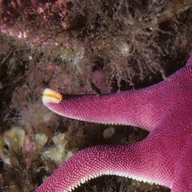

In [27]:
display(torchvision.transforms.ToPILImage()(data_display[0][1]))

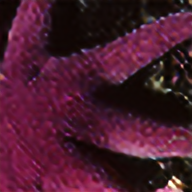

In [59]:
display(torchvision.transforms.ToPILImage()(son.model(data_display[0][0].unsqueeze(dim=0).to(DEVICE)).clamp_(0,1)[0]))

In [60]:
gan.vgg_loss.vgg((data_display[0][0]).unsqueeze(dim=0).to(DEVICE)).mean()

tensor(-2.7434, device='cuda:0')

In [61]:
gan.vgg_loss(son.model((data_train[0][0]).unsqueeze(dim=0).to(DEVICE)), (data_train[0][1]).unsqueeze(dim=0).to(DEVICE))

tensor(1.6639, device='cuda:0', grad_fn=<MeanBackward0>)